In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test1.csv")
train.head(10) 

NameError: name 'pd' is not defined

In [3]:
train.groupby("label").size() #check target size

label
-1    31371
 1       57
dtype: int64

In [4]:
train.drop(["id","purchaseTime","hour"],axis=1,inplace=True)
test.drop(["id","purchaseTime","hour"],axis=1,inplace=True)  #delete useless value

In [5]:
X=train.drop("label",axis=1)
y=train["label"]
X_pred=test.drop("label",axis=1)
y_pred=test["label"]

# Feature Selection

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
# from sklearn.feature_selection import SelectFromModel
feat_labels=X.columns.values.tolist()
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

In [7]:
# Train the classifier
clf.fit(X,y)
# Print the name and gini importance of each feature
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

('visitTime', 0.08237191978725307)
('C1', 0.04509466450531865)
('C2', 0.019124518387993953)
('C3', 0.03779532583119887)
('C4', 0.010240116041685255)
('C5', 0.006575345770739008)
('C6', 0.045893151928789296)
('C7', 0.030913165643319147)
('C8', 0.02279993406204759)
('N1', 0.02631505187129015)
('C9', 0.028704179163977227)
('N2', 0.009436053603444761)
('N3', 0.03049084564175966)
('N4', 0.02352358329712975)
('N5', 0.00577515530294264)
('N6', 0.09679732093141856)
('N7', 0.005500438406235134)
('N8', 0.04437183069543574)
('N9', 0.19004320867380683)
('N10', 0.13575320224415743)
('C10', 0.0709870952318239)
('C11', 0.012266906241492865)
('C12', 0.01922698673674059)


In [8]:
X=X[["visitTime",'C1',"C6","C10",'N6', 'N8', 'N9', 'N10']]
X_pred=X_pred[["visitTime",'C1',"C6","C10",'N6', 'N8', 'N9', 'N10']]
X

,visitTime,C1,C6,C10,N6,N8,N9,N10
0,19274330,2569487005,3624739744,419316267,0,0,0,0
1,19274334,3191875643,179712055,1968545380,0,1,0,0
2,19274353,2634604934,1607619193,1405802835,0,0,0,0
3,19274358,2569487005,10212495,2299319102,0,0,0,0
4,19274367,2569487005,580883881,1306075469,0,0,0,0
...,...,...,...,...,...,...,...,...
31423,19360259,2569487005,3624739744,773194559,0,0,0,0
31424,19360260,2569487005,3624739744,4038791635,0,0,0,0
31425,19360392,497926344,2304197778,1169636883,0,0,0,0
31426,19360528,2569487005,3624739744,357042422,0,0,0,0


# Undersampling and Oversampling

In [9]:
from imblearn.over_sampling import  SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(sampling_strategy={-1: 10000 }, random_state=0)
X_rus, y_rus = rus.fit_sample(X, y)
smo = SMOTENC(sampling_strategy={1: 500 },categorical_features=[1,2,3],random_state=42)
X_res, y_res = smo.fit_sample(X_rus, y_rus)

# fix the oversampling and undersampling problem of  train module , fix the sample distrubution in the same time.
print('Resampled dataset shape %s' % Counter(y_res))

Using TensorFlow backend.


Resampled dataset shape Counter({-1: 10000, 1: 500})


# Standarlize & Modeling

In [10]:
scaler = StandardScaler()
X_pred=scaler.fit_transform(X_pred)
X_res_scaled=scaler.fit_transform(X_res)
X_fit=scaler.fit_transform(X)

In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [12]:
result = cross_val_score(logreg, X_res_scaled, y_res, cv=10, scoring='recall')
np.mean(result)

0.744

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
X_train,X_test,y_train,y_test = train_test_split(X_res_scaled, y_res,stratify=y_res, test_size = 0.3 , random_state = 42)
model=logreg.fit(X_train,y_train)

In [14]:
model.score(X_test,y_test)

0.9831746031746031

# ROC

In [15]:
y_score=model.decision_function(X_test)

<Figure size 432x288 with 0 Axes>

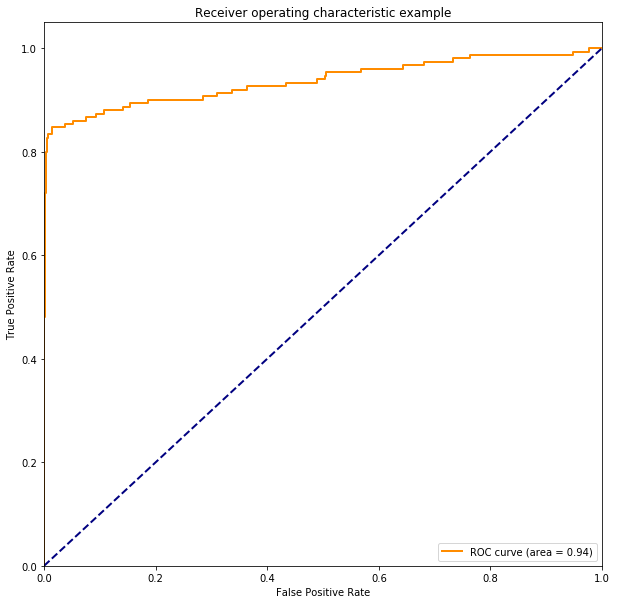

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc 
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_score) ###caculate false positive and true positive
roc_auc = auc(fpr,tpr) ###caculate auc
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Fit Test (Overfitted?)

In [18]:
Y_fit = model.predict(X_fit)
print(classification_report(y,Y_fit))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     31371
           1       0.24      0.82      0.38        57

    accuracy                           1.00     31428
   macro avg       0.62      0.91      0.69     31428
weighted avg       1.00      1.00      1.00     31428



# Apply model and store result

In [19]:
prediction1= model.predict_proba(X_pred)
prediction1=pd.DataFrame(prediction1)
prediction1

,0,1
0,0.972745,0.027255
1,0.958371,0.041629
2,0.976319,0.023681
3,0.938507,0.061493
4,0.978269,0.021731
...,...,...
32081,0.991706,0.008294
32082,0.988147,0.011853
32083,0.986125,0.013875
32084,0.989658,0.010342


In [20]:
prediction = pd.DataFrame()
prediction["ID"]=np.arange(2,32088)
prediction.shape
model.predict(X_pred)
prediction["Prob"] = prediction1[1]
prediction.to_csv("test_prob.csv",index=False,sep=',')

In [21]:
resu=model.predict(X_pred)
print('Result dataset shape %s' % Counter(resu))

Result dataset shape Counter({-1: 31927, 1: 159})
